In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

2024-11-13 22:20:29.579529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 22:20:29.623132: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 22:20:29.623699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 22:20:30.529453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(1000, 70) (70,) (1000, 25, 70)


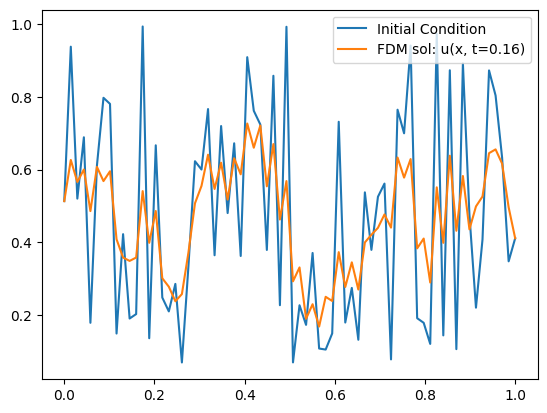

In [151]:
# Generating Data
alpha = 0.001 
n_points = 70                  
n_datasets = 1000               # number of diff datasets
time_final = 2.0                # time where its evaluated
delta_t = 0.08
delta_x = 1.0 / n_points        
X_coord = np.linspace(0, 1, n_points)     # domain (0,1)
n_steps = int(time_final / delta_t)
T = np.linspace(0, time_final, n_steps)            # time domain (0,1)

initial_heats = np.random.rand(n_datasets, n_points)
def heat_1d_data_generate(initial_heats, n_datasets):
    
    
    Y_data = np.zeros((n_datasets, n_steps, n_points))

    for d in range(n_datasets):
        u = initial_heats[d].copy()
        Y_data[d, 0] = u  
        for i in range(1, n_steps):
            u[1:-1] += alpha * delta_t / delta_x**2 * (u[2:] - 2 * u[1:-1] + u[:-2])  
            Y_data[d, i] = u  

    return initial_heats, Y_data


idx = 4
t_idx = 2
time = t_idx*delta_t
X_train, Y_train = heat_1d_data_generate(initial_heats, n_datasets)
plt.plot(X_coord, X_train[4], label = f"Initial Condition")
print(X_train.shape, X_coord.shape, Y_train.shape)
plt.plot(X_coord, Y_train[4][2], label = f"FDM sol: u(x, t={time})")
plt.legend()


    

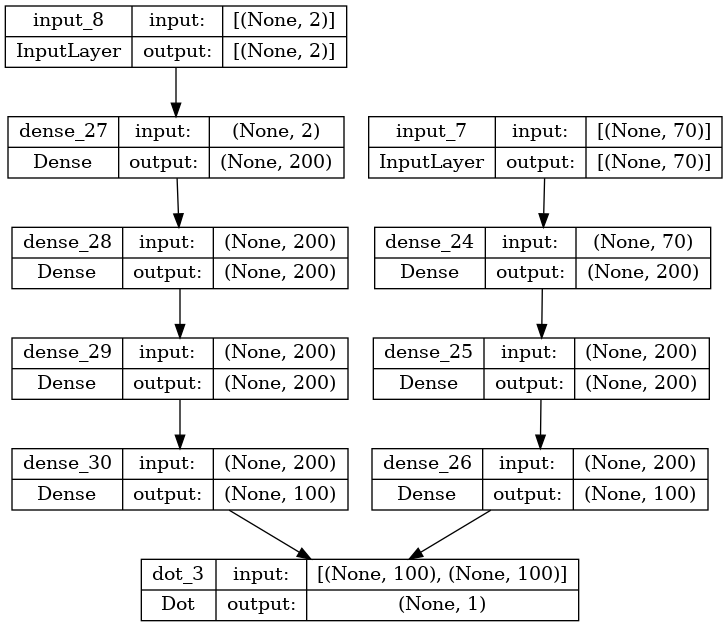

In [68]:
# DeepONet Architecture


from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import plot_model


# Branch Network
branch_input = Input(shape=(n_points,))
x_branch = branch_input
for _ in range(2):
    x_branch = layers.Dense(200, activation='relu')(x_branch)
branch_output = layers.Dense(100)(x_branch)

# Trunk Network
trunk_input = Input(shape=(2,))
x_trunk = trunk_input
for _ in range(3):
    x_trunk = layers.Dense(200, activation='relu')(x_trunk)
trunk_output = layers.Dense(100)(x_trunk)

# Combine
final_output = layers.Dot(axes=-1)([branch_output, trunk_output])

deeponet_model = Model(inputs=[branch_input, trunk_input], outputs=final_output)

plot_model(deeponet_model, to_file="deeponet_model.png", show_shapes=True, show_layer_names=True)


In [4]:
# X_space_time_coord = np.array([(x, t) for t in T for x in X_coord])
# X_space_time_coord.shape

# X_train_initials = np.repeat(X_train, len(query_coord_time), axis=0)
# X_train_locations = np.tile(X_space_time_coord, (X_train.shape[0], 1))
# Y_train_flat = Y_train.flatten()

In [69]:
X_train /= X_train.max()
Y_train /= Y_train.max()


In [70]:
query_coord = X_coord.reshape(-1,1)
query_time = T.reshape(-1,1)

query_coord_time = np.array([[t, x] for t in T for x in X_coord ])  #change
X_train_initials = np.repeat(X_train, n_steps * n_points, axis=0)
X_train_query = np.tile(query_coord_time, (n_datasets, 1))
Y_train_flat = Y_train.reshape(-1)

print("Branch Input:", X_train_initials.shape)  
print("Trunk Input:", X_train_query.shape)      
print("Labels:", Y_train_flat.shape)         

deeponet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
history = deeponet_model.fit([X_train_initials, X_train_query], Y_train_flat, epochs=100, validation_split=0.2, batch_size=500)



Branch Input: (1750000, 70)
Trunk Input: (1750000, 2)
Labels: (1750000,)


2024-11-14 00:24:47.358074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 392000000 exceeds 10% of free system memory.


Epoch 1/100
2800/2800 [==============================] - 20s 7ms/step - loss: 0.0100 - val_loss: 0.0062
Epoch 2/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 3/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 4/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 7/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/100
2800/2800 [==============================] - 19s 7m

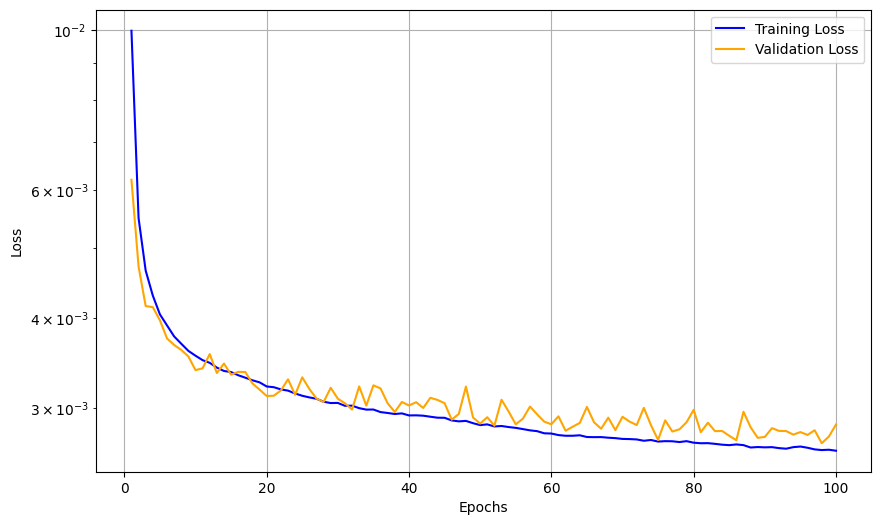

In [71]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create the semilog plot
plt.figure(figsize=(10, 6))
plt.semilogy(epochs, train_loss, label='Training Loss', color='blue')
plt.semilogy(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [100]:
# Quantitative Evaluation
n_test_samples = 100

X_test, Y_test = heat_1d_data_generate(n_test_samples)
print(Y_test.shape)

X_test_initials = np.repeat(X_test, len(query_coord_time), axis=0)
# X_test_spatial = np.tile(query_coord, (X_test.shape[0], 1))
X_train_query = np.tile(query_coord_time, (X_test.shape[0], 1))

Y_test_flat = Y_test.flatten()
print(X_test_initials.shape, X_train_query.shape, Y_test_flat.shape)

test_loss = deeponet_model.evaluate([X_test_initials, X_train_query], Y_test_flat)
print("Test Loss:", test_loss)

(100, 25, 70)
(175000, 70) (175000, 2) (175000,)
5469/5469 [==============================] - 7s 1ms/step - loss: 0.0028
Test Loss: 0.0028430481906980276


In [101]:
# Qualitative Evaluation

pred_Y = deeponet_model.predict([X_test_initials, X_train_query]).flatten()
pred_Y = pred_Y.reshape(Y_test.shape)
pred_Y.shape


5469/5469 [==============================] - 7s 1ms/step


(100, 25, 70)

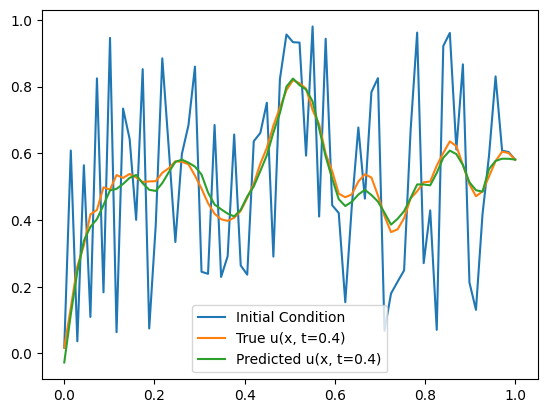

In [128]:
idx = 69  # Test sample index (0 to 100)
t_idx = 5  # Time point (0 to 25)
time = t_idx*delta_t
plt.plot(X_coord, X_test[idx], label = "Initial Condition")
plt.plot(X_coord, Y_test[idx][t_idx], label = f"True u(x, t={time})")
plt.plot(X_coord, pred_Y[idx][t_idx], label = f"Predicted u(x, t={time})")
plt.legend()

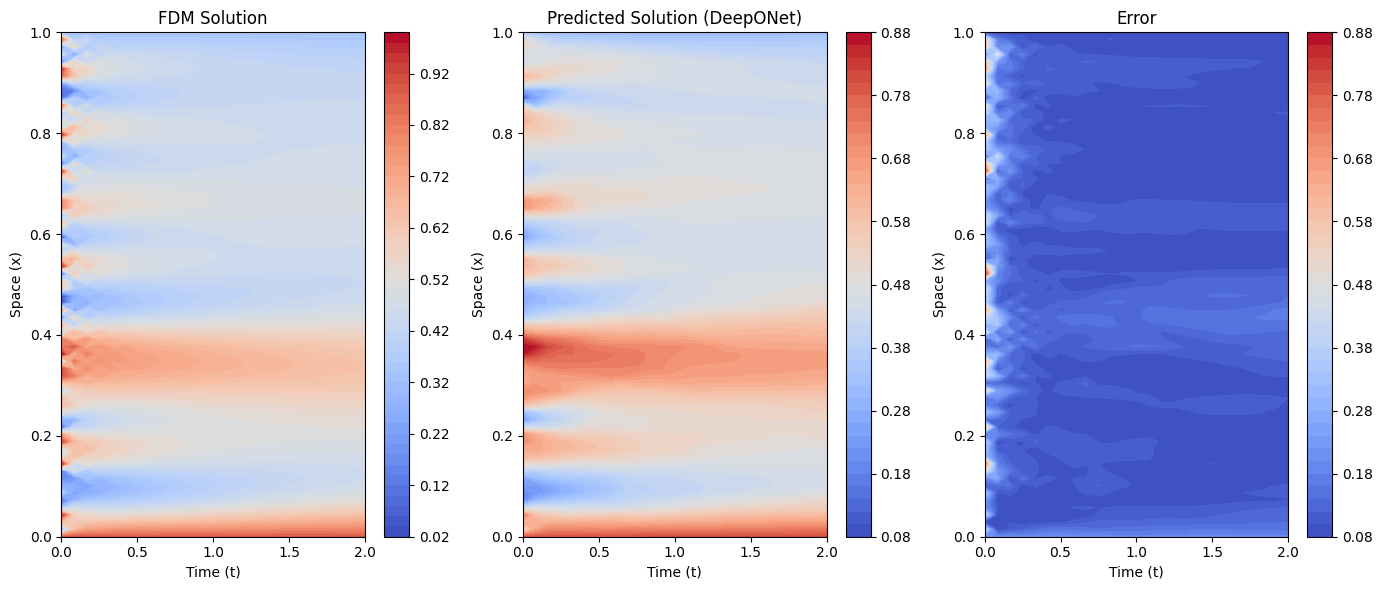

In [142]:
# spatio temporal plot comparison
idx = 44
true_u = Y_test[idx]  
predicted_u = pred_Y[idx]  


T = np.linspace(0, time_final, n_steps)  
X = X_coord
X, T = np.meshgrid(X, T)

fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# FDM solution
c1 = axs[0].contourf(T, X, true_u, levels=50, cmap='coolwarm')
fig.colorbar(c1, ax=axs[0])
axs[0].set_title("FDM Solution")
axs[0].set_xlabel("Time (t)")
axs[0].set_ylabel("Space (x)")

# Predicted solution
c2 = axs[1].contourf(T, X, predicted_u, levels=50, cmap='coolwarm')
fig.colorbar(c2, ax=axs[1])
axs[1].set_title("Predicted Solution (DeepONet)")
axs[1].set_xlabel("Time (t)")
axs[1].set_ylabel("Space (x)")

# Difference
c3 = axs[2].contourf(T, X, abs(true_u-predicted_u), levels=50, cmap='coolwarm')
fig.colorbar(c2, ax=axs[2])
axs[2].set_title("Error")
axs[2].set_xlabel("Time (t)")
axs[2].set_ylabel("Space (x)")

plt.tight_layout()
plt.show()


In [146]:

deeponet_model.save('deeponet_model_heat_1d.h5')
loaded_model = tf.keras.models.load_model('deeponet_model_heat_1d.h5')


/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 1ms/step


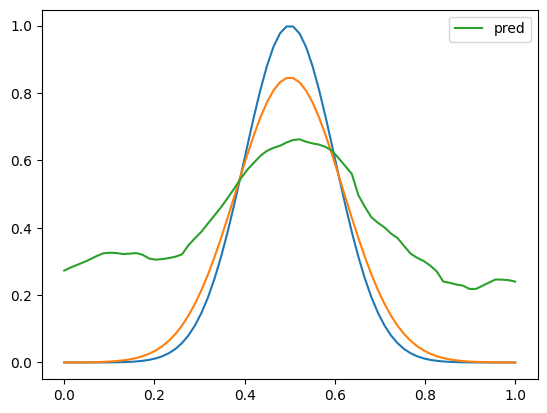

In [166]:
def gaussian_initial_condition(x, mean=0.5, sigma=0.1):
    return np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))

X_test = gaussian_initial_condition(X_coord).reshape(1, -1)  # Shape: (1, 70)
# X_test = np.random.rand(1, n_points)
X_test, Y_test = heat_1d_data_generate(X_test, 1)
X_test_initials = np.repeat(X_test, 25 * 70, axis=0)  # Repeat initial condition
X_test_query = np.tile(query_coord_time, (1, 1))  # Shape: (25 * 70, 2)
pred_Y = loaded_model.predict([X_test_initials, X_test_query]).flatten()

pred_Y = pred_Y.reshape((25,70))  # Reshape to (1, 25, 70)

plt.plot(X_coord, X_test.T)
plt.plot(X_coord, Y_test[0][24])
plt.plot(X_coord, pred_Y[24], label="pred")

plt.legend()